In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import flax
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array,PyTree

import matplotlib.pyplot as plt

In [3]:
from architectures.node import NeuralODE
from architectures.utils_node import eval_model
from architectures.architectures import MLP,ResNet
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.functions import zero_potential_fn
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.hamiltonian_flow_step import hamiltonian_flow_step
from flows.hamiltonian_flow import initialize_momentum, run_hamiltonian_flow, hamiltonian_trajectory
from parametric_model.parametric_model import ParametricModel
from terminal_criteria.gaussian_case import guassian_wasserstein_squared_distance


In [4]:
def cost_functional(p_0: PyTree,
                   parametric_model: nnx.Module,
                   batch_size: int,
                   test_data_set: Array,
                   G_mat: G_matrix,
                   potential: Potential,
                   Sigma_target: Array,
                   alpha: float = 1.0,
                   h: float = 0.01,
                   solver: str = "cg",
                   max_iterations: int = 100,
                   regularization: float = 1e-6,
                   gamma: float = 1e-2,
                   n_iters: int = 3,
                   solver_tol: float = 1e-6,
                   solver_maxiter: int = 50) -> float:
    """
    Compute the full cost functional:
    J(p₀) = α * W₂²((T_{θ₁})_# λ, ρ₁) + A[θ(·)]
    
    This function is fully differentiable w.r.t. p_0 via JAX autodiff.
    Both terms are computed from a single forward solve of the Hamiltonian system.
    
    Args:
        p_0: Initial momentum PyTree
        parametric_model: Initial ParametricModel
        batch_size: Number of samples for Monte Carlo
        test_data_set: Test dataset
        G_mat: G-matrix object
        potential: Potential instance
        Sigma_target: Target covariance matrix (d, d)
        alpha: Weight for Wasserstein term (α > 0)
        h: Time step size
        solver: Linear solver type
        max_iterations: Number of Hamiltonian steps
        [other solver parameters...]
    
    Returns:
        cost: Scalar value J(p₀) = α * W₂² + Action
    """
    
    # ===== SINGLE FORWARD SOLVE =====
    # Run Hamiltonian trajectory from p₀
    trajectories = hamiltonian_trajectory(
        parametric_model=parametric_model,
        batch_size=batch_size,
        test_data_set=test_data_set,
        G_mat=G_mat,
        potential=potential,
        initial_momentum=p_0,
        h=h,
        solver=solver,
        max_iterations=max_iterations,
        regularization=regularization,
        gamma=gamma,
        n_iters=n_iters,
        solver_tol=solver_tol,
        solver_maxiter=solver_maxiter
    )
    
    # Extract trajectories
    theta_history = trajectories['theta_history']
    momentum_history = trajectories['momentum_history']
    theta_final = theta_history[-1]  # θ(1)
    n_steps = len(theta_history)
    
    # ===== TERM 1: WASSERSTEIN DISTANCE =====
    # Extract weight matrix from final parameters θ₁
    theta_final_leaves = jax.tree.leaves(theta_final)
    W_final = theta_final_leaves[0]  # (d, d) weight matrix
    
    # Compute W₂²((T_{θ₁})_# λ, ρ₁)
    wasserstein_squared = guassian_wasserstein_squared_distance(W_final, Sigma_target)
    
    # ===== TERM 2: ACTION FUNCTIONAL =====
    # Generate samples for G matrix computation
    key = jax.random.PRNGKey(0)
    problem_dim = test_data_set.shape[1]
    z_samples = jax.random.normal(key, (batch_size, problem_dim))
    
    # Compute kinetic energy at each time step: KE(t) = ½ p^T G^{-1} p
    kinetic_energies = []
    
    for i in range(n_steps):
        theta_i = theta_history[i]
        p_i = momentum_history[i]
        
        # Solve G(θᵢ) ηᵢ = pᵢ
        # eta_i, _ = G_mat.solve_system(
        #     z_samples=z_samples,
        #     b=p_i,
        #     params=theta_i,
        #     tol=solver_tol,
        #     maxiter=solver_maxiter,
        #     method=solver,
        #     regularization=regularization
        # )
        
        # # KE = ½ p^T G^{-1} p
        # ke_i = 0.5 * sum(jax.tree.leaves(jax.tree.map(
        #     lambda p, eta: jnp.sum(p * eta), p_i, eta_i
        # )))
        ke_i = G_mat.inner_product(p_i,p_i,z_samples,theta_i)
        kinetic_energies.append(ke_i)
    
    kinetic_energies = jnp.array(kinetic_energies)
    
    # Trapezoidal integration for action
    action = h * (
        kinetic_energies[0] / 2.0 +
        jnp.sum(kinetic_energies[1:-1]) +
        kinetic_energies[-1] / 2.0
    )

    jax.debug.print("Wasserstein Squared: {ws}, Action: {ac}", ws=wasserstein_squared, ac=action)
    
    # ===== COMBINE TERMS =====
    total_cost =  wasserstein_squared + alpha*action
    
    return total_cost

In [5]:
from typing import Tuple
def optimize_initial_momentum(
    p_0_init: PyTree,
    parametric_model: nnx.Module,
    batch_size: int,
    test_data_set: Array,
    G_mat: G_matrix,
    potential: Potential,
    Sigma_target: Array,
    alpha: float = 1.0,
    h: float = 0.01,
    solver: str = "cg",
    max_iterations: int = 100,
    # Hamiltonian solver params
    regularization: float = 1e-6,
    gamma: float = 1e-2,
    n_iters: int = 3,
    solver_tol: float = 1e-6,
    solver_maxiter: int = 50,
    # Optimization params
    optimizer: str = "adam",
    learning_rate: float = 1e-3,
    num_optimization_steps: int = 100,
    verbose: bool = True
) -> dict:
    """
    Optimize initial momentum p₀ to minimize the cost functional J(p₀).
    
    Args:
        p_0_init: Initial guess for momentum
        parametric_model: Initial ParametricModel
        batch_size: Number of samples for Monte Carlo
        test_data_set: Test dataset
        G_mat: G-matrix object
        potential: Potential instance
        Sigma_target: Target covariance matrix (d, d)
        alpha: Weight for Wasserstein term
        h: Time step for Hamiltonian flow
        solver: Linear solver type
        max_iterations: Number of Hamiltonian steps
        [Hamiltonian solver params...]
        optimizer: Optimizer type ("adam", "sgd", "rmsprop")
        learning_rate: Learning rate for optimizer
        num_optimization_steps: Number of optimization iterations
        verbose: Print progress
    
    Returns:
        results: Dictionary containing:
            - 'optimal_p0': Optimized initial momentum
            - 'optimal_cost': Final cost value
            - 'cost_history': List of cost values during optimization
            - 'wasserstein_history': List of Wasserstein distances
            - 'action_history': List of action values
            - 'grad_norm_history': List of gradient norms
            - 'final_theta': Final parameters θ(1) from optimal p₀
    """
    
    import optax
    
    # Define the cost function with fixed parameters
    def cost_fn(p_0: PyTree) -> float:
        return cost_functional(
            p_0=p_0,
            parametric_model=parametric_model,
            batch_size=batch_size,
            test_data_set=test_data_set,
            G_mat=G_mat,
            potential=potential,
            Sigma_target=Sigma_target,
            alpha=alpha,
            h=h,
            solver=solver,
            max_iterations=max_iterations,
            regularization=regularization,
            gamma=gamma,
            n_iters=n_iters,
            solver_tol=solver_tol,
            solver_maxiter=solver_maxiter
        )
    
    # Function to compute cost and separate components for logging
    def cost_fn_detailed(p_0: PyTree) -> Tuple[float, dict]:
        """Compute cost and return detailed breakdown."""
        # Run trajectory
        trajectories = hamiltonian_trajectory(
            parametric_model=parametric_model,
            batch_size=batch_size,
            test_data_set=test_data_set,
            G_mat=G_mat,
            potential=potential,
            initial_momentum=p_0,
            h=h,
            solver=solver,
            max_iterations=max_iterations,
            regularization=regularization,
            gamma=gamma,
            n_iters=n_iters,
            solver_tol=solver_tol,
            solver_maxiter=solver_maxiter
        )
        
        # Wasserstein term
        theta_final = trajectories['theta_history'][-1]
        theta_final_leaves = jax.tree.leaves(theta_final)
        W_final = theta_final_leaves[0]
        wasserstein_sq = guassian_wasserstein_squared_distance(W_final, Sigma_target)
        
        # Action term (recompute for logging)
        theta_history = trajectories['theta_history']
        momentum_history = trajectories['momentum_history']
        key = jax.random.PRNGKey(0)
        problem_dim = test_data_set.shape[1]
        z_samples = jax.random.normal(key, (batch_size, problem_dim))
        
        kinetic_energies = []
        for theta_i, p_i in zip(theta_history, momentum_history):
            ke_i = G_mat.inner_product(p_i,p_i,z_samples,theta_i)
            kinetic_energies.append(ke_i)
        
        kinetic_energies = jnp.array(kinetic_energies)
        action = h * (kinetic_energies[0] / 2.0 + jnp.sum(kinetic_energies[1:-1]) + 
                     kinetic_energies[-1] / 2.0)
        
        total_cost =  wasserstein_sq + action*alpha
        
        return total_cost, {
            'wasserstein': float(wasserstein_sq),
            'action': float(action),
            'theta_final': theta_final
        }
    
    # Setup optimizer
    if optimizer == "adam":
        opt = optax.adam(learning_rate)
    elif optimizer == "sgd":
        opt = optax.sgd(learning_rate)
    elif optimizer == "rmsprop":
        opt = optax.rmsprop(learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")
    
    opt_state = opt.init(p_0_init)
    
    # Initialize current momentum
    current_p0 = p_0_init
    
    # Storage for history
    cost_history = []
    wasserstein_history = []
    action_history = []
    grad_norm_history = []
    
    # Optimization loop
    if verbose:
        print(f"Starting optimization with {optimizer}, lr={learning_rate}")
        print(f"{'Step':<6} {'Cost':<12} {'Wasserstein²':<12} {'Action':<12} {'||∇||':<12}")
        print("-" * 60)
        
    key = jax.random.PRNGKey(0)
    
    for step in range(num_optimization_steps):
        # Compute cost, gradient, and detailed info
        cost_val, grad_p0 = jax.value_and_grad(cost_fn)(current_p0)
        
        # Compute gradient norm
        # grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(
        #     lambda g: jnp.sum(g**2), grad_p0
        # ))))
        key,subkey = jax.random.split(key)
        z_samples = jax.random.normal(subkey, (batch_size, test_data_set.shape[1]))
        grad_norm = G_mat.inner_product(grad_p0,grad_p0,z_samples)
        # Get detailed breakdown (for logging only)
        if verbose and (step % 10 == 0 or step == num_optimization_steps - 1):
            _, details = cost_fn_detailed(current_p0)
            wasserstein_val = details['wasserstein']
            action_val = details['action']
            theta_final = details['theta_final']
            
            print(f"{step:<6} {cost_val:<12.6f} {wasserstein_val:<12.6f} "
                  f"{action_val:<12.6f} {grad_norm:<12.6e}")
            
            wasserstein_history.append(wasserstein_val)
            action_history.append(action_val)
            if step > 0:
                prev_terminal_samples = terminal_samples
            # Print pushforward of theta final
            terminal_samples = parametric_model(samples=z_samples, params=theta_final)
            plt.scatter(terminal_samples[:,0], terminal_samples[:,1],label='Current Step')
            if step > 0:
                plt.scatter(prev_terminal_samples[:,0], prev_terminal_samples[:,1],label='Previous Step',alpha=0.5)
            plt.legend()
            plt.title(f"Step {step} Terminal Samples")
            plt.show()
            

            
        
        cost_history.append(float(cost_val))
        grad_norm_history.append(float(grad_norm))
        
        # Update parameters using optimizer
        updates, opt_state = opt.update(grad_p0, opt_state, current_p0)
        current_p0 = optax.apply_updates(current_p0, updates)
    
    # Final evaluation
    final_cost, final_details = cost_fn_detailed(current_p0)
    
    if verbose:
        print("-" * 60)
        print(f"Optimization complete!")
        print(f"Initial cost: {cost_history[0]:.6f}")
        print(f"Final cost:   {final_cost:.6f}")
        print(f"Improvement:  {cost_history[0] - final_cost:.6f}")
    
    return {
        'optimal_p0': current_p0,
        'optimal_cost': float(final_cost),
        'cost_history': cost_history,
        'wasserstein_history': wasserstein_history,
        'action_history': action_history,
        'grad_norm_history': grad_norm_history,
        'final_theta': final_details['theta_final'],
        'final_wasserstein': final_details['wasserstein'],
        'final_action': final_details['action']
    }

In [6]:
dim = 20
n_samples = 2_000
# Setup your test case
parametric_model = ParametricModel(
    parametric_map="mlp",
    architecture=[dim, 0, dim],
    scale_factor=1e-5,  # Small perturbation for numerical stability
    time_dependent = False,
    dt0=0.1
)

In [7]:
key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)
# Generate reference samples from lambda = N(0, I)
key, subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (n_samples, dim))
G_mat = G_matrix(parametric_model)

In [8]:
zero_potential = LinearPotential(zero_potential_fn)
potential = Potential(zero_potential)

In [9]:
gamma = 1e-2
opt_steps = 50

Starting optimization with adam, lr=0.075
Step   Cost         Wasserstein² Action       ||∇||       
------------------------------------------------------------


/work/Sebas/PATHF/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:113: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  Tk_under = jnp.zeros((k + 1, k), dtype=jnp.float64)
/work/Sebas/PATHF/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:120: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rhs = jnp.zeros((k + 1,), dtype=jnp.float64).at[0].set(beta1)


Wasserstein Squared: 47.44249725341797, Action: 0.034871168434619904


2026-01-27 12:16:52.342189: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


0      47.442844    47.442497    0.034871     1.667583e+02


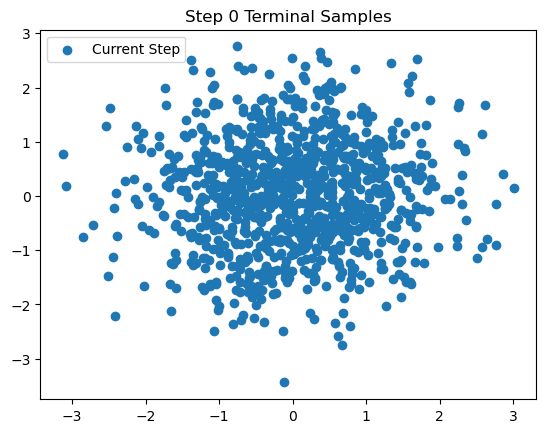

Wasserstein Squared: 44.651973724365234, Action: 2.0207855701446533
Wasserstein Squared: 39.584495544433594, Action: 2.6348683834075928
Wasserstein Squared: 34.115081787109375, Action: 4.036031246185303
Wasserstein Squared: 28.783065795898438, Action: 6.937935829162598
Wasserstein Squared: 23.611112594604492, Action: 11.410057067871094
Wasserstein Squared: 18.796890258789062, Action: 17.430490493774414
Wasserstein Squared: 14.4132080078125, Action: 24.88389015197754
Wasserstein Squared: 10.708738327026367, Action: 33.5468864440918
Wasserstein Squared: 7.772295951843262, Action: 43.0528564453125
Wasserstein Squared: 5.607958793640137, Action: 52.9313850402832
10     6.137273     5.607959     52.931385    1.985419e+01


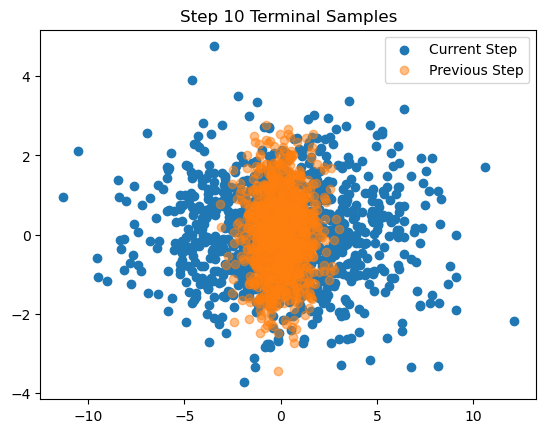

Wasserstein Squared: 4.052437782287598, Action: 62.646968841552734
Wasserstein Squared: 3.045679807662964, Action: 71.6353530883789
Wasserstein Squared: 2.361793041229248, Action: 79.41698455810547
Wasserstein Squared: 2.094829559326172, Action: 85.63648223876953
Wasserstein Squared: 1.8720448017120361, Action: 90.19548797607422
Wasserstein Squared: 1.775012731552124, Action: 93.11475372314453
Wasserstein Squared: 1.7339591979980469, Action: 94.642578125
Wasserstein Squared: 1.679794430732727, Action: 95.01595306396484
Wasserstein Squared: 1.653417706489563, Action: 94.50395965576172
Wasserstein Squared: 1.6267709732055664, Action: 93.35914611816406
20     2.560362     1.626771     93.359146    6.279109e+00


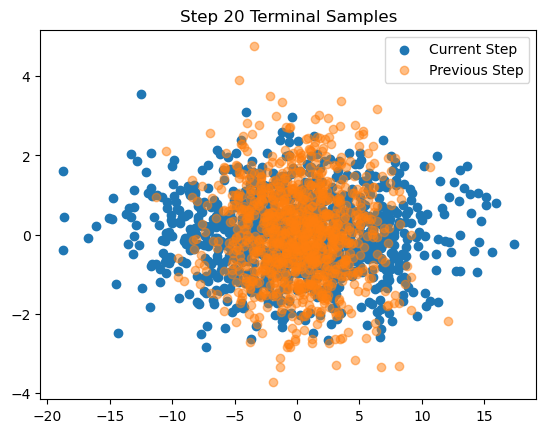

Wasserstein Squared: 1.5476945638656616, Action: 91.81990051269531
Wasserstein Squared: 1.4361501932144165, Action: 90.08009338378906
Wasserstein Squared: 1.4091960191726685, Action: 88.24238586425781
Wasserstein Squared: 1.3606812953948975, Action: 86.3503189086914
Wasserstein Squared: 1.2863520383834839, Action: 84.44156646728516
Wasserstein Squared: 1.192786455154419, Action: 82.51466369628906
Wasserstein Squared: 1.1198551654815674, Action: 80.56084442138672
Wasserstein Squared: 0.9619098901748657, Action: 78.55784606933594
Wasserstein Squared: 0.8877391815185547, Action: 76.54266357421875
Wasserstein Squared: 0.7655254602432251, Action: 74.5399169921875
30     1.510925     0.765525     74.539917    3.536448e+00


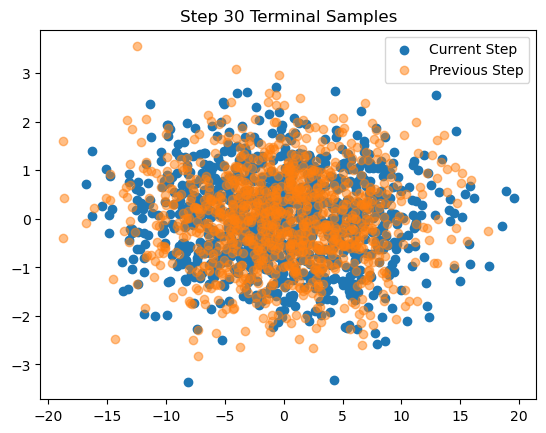

Wasserstein Squared: 0.6745043992996216, Action: 72.61434173583984
Wasserstein Squared: 0.5912264585494995, Action: 70.77993774414062
Wasserstein Squared: 0.5066323280334473, Action: 69.07921600341797
Wasserstein Squared: 0.4246642589569092, Action: 67.51001739501953
Wasserstein Squared: 0.3389132022857666, Action: 66.10265350341797
Wasserstein Squared: 0.2675058841705322, Action: 64.88330841064453
Wasserstein Squared: 0.23403549194335938, Action: 63.881103515625
Wasserstein Squared: 0.23035621643066406, Action: 63.05427169799805
Wasserstein Squared: 0.19634723663330078, Action: 62.372772216796875
Wasserstein Squared: 0.16679048538208008, Action: 61.81728744506836
40     0.784963     0.166790     61.817287    8.429503e-01


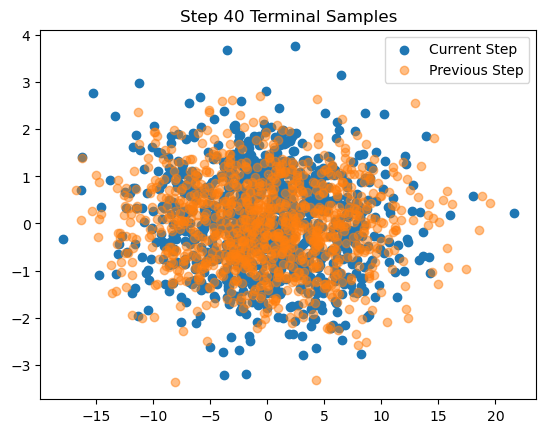

Wasserstein Squared: 0.1843855381011963, Action: 61.387550354003906
Wasserstein Squared: 0.1853625774383545, Action: 61.11335372924805
Wasserstein Squared: 0.1682419776916504, Action: 60.982276916503906
Wasserstein Squared: 0.2582132816314697, Action: 60.96552276611328
Wasserstein Squared: 0.2653501033782959, Action: 61.038063049316406
Wasserstein Squared: 0.25987255573272705, Action: 61.15128707885742
Wasserstein Squared: 0.2694178819656372, Action: 61.31136703491211
Wasserstein Squared: 0.2115854024887085, Action: 61.521907806396484
Wasserstein Squared: 0.19012808799743652, Action: 61.81240463256836
Wasserstein Squared: 0.1889744997024536, Action: 62.150184631347656
50     0.810476     0.188974     62.150185    8.893655e-01


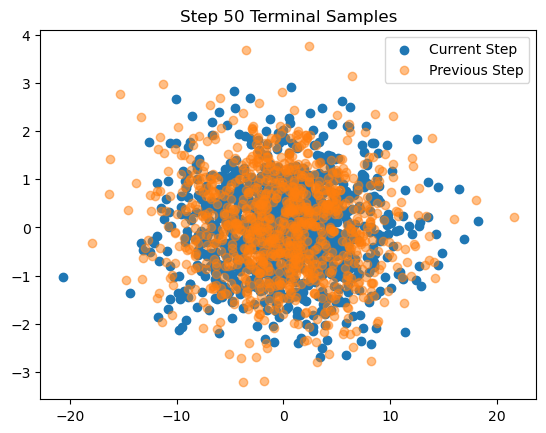

Wasserstein Squared: 0.21407949924468994, Action: 62.507659912109375
Wasserstein Squared: 0.22409594058990479, Action: 62.857887268066406
Wasserstein Squared: 0.1872847080230713, Action: 63.17115020751953
Wasserstein Squared: 0.09358775615692139, Action: 63.48698806762695
Wasserstein Squared: 0.059023141860961914, Action: 63.79104232788086
Wasserstein Squared: 0.06486010551452637, Action: 64.12557220458984
Wasserstein Squared: 0.06850481033325195, Action: 64.43196868896484
Wasserstein Squared: 0.10764062404632568, Action: 64.67012786865234
Wasserstein Squared: 0.07930457592010498, Action: 64.82262420654297
59     0.727531     0.079305     64.822624    6.923150e-01


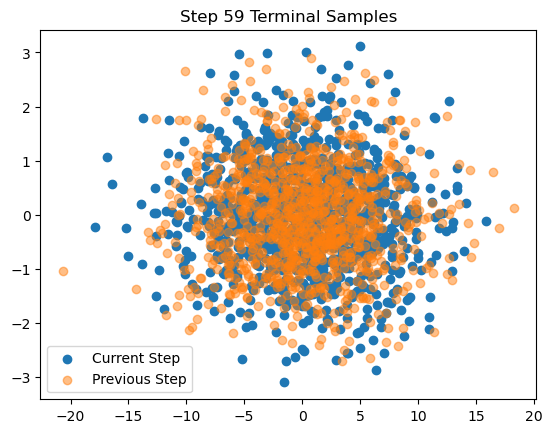

------------------------------------------------------------
Optimization complete!
Initial cost: 47.442844
Final cost:   0.717005
Improvement:  46.725842
Final Wasserstein distance: 0.261292


In [10]:


# Initialize momentum (e.g., zeros or small random)
_, p_0_init = nnx.split(parametric_model)
p_0_init = jax.tree.map(lambda x: 0.01 * jax.random.normal(jax.random.PRNGKey(0), x.shape), p_0_init)
# p_0_init = jax.tree.map(jnp.zeros_like, p_0_init)

# Target Gaussian
# Sigma_target =   # N(0, 2I)
Sigma_target = 5*jnp.eye(dim)
Sigma_target = Sigma_target.at[0:2,0:2].set(jnp.array([[30.0, -.5], [-.5, 1.0]]))

h = 0.1
max_iterations = int(1/h)
opt_steps = 60

# Run optimization
results = optimize_initial_momentum(
    p_0_init=p_0_init,
    parametric_model=parametric_model,
    batch_size=1000,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    Sigma_target=Sigma_target,
    alpha=0.010,
    h=h,
    solver="cg",
    max_iterations=max_iterations,
    optimizer="adam",
    learning_rate=0.075,
    num_optimization_steps=opt_steps,
    verbose=True
)

# Access results
optimal_p0 = results['optimal_p0']
final_theta = results['final_theta']
print(f"Final Wasserstein distance: {jnp.sqrt(results['final_wasserstein']):.6f}")

In [11]:
optimal_p0

State({
  'model': {
    'layers': {
      0: {
        'kernel': VariableState( # 400 (1.6 KB)
          type=Param,
          value=Array([[ 1.29980445e+00, -1.87200159e-01,  6.73844993e-01,
                   3.79914343e-01,  6.54955506e-01,  2.67175615e-01,
                   7.40474582e-01,  3.68163496e-01, -4.17169094e-01,
                  -2.42562845e-01,  4.69019324e-01, -3.40815634e-01,
                   8.68410110e-01,  4.58895475e-01,  5.24168074e-01,
                   4.64058101e-01, -5.66464186e-01, -2.38785818e-01,
                   4.25161272e-01, -5.25761366e-01],
                 [-1.23816705e+00, -5.25510192e-01,  5.08976221e-01,
                  -3.28644156e-01, -5.31067789e-01, -4.81154621e-01,
                   5.46547651e-01,  5.54046094e-01, -6.02715075e-01,
                  -5.78635514e-01,  1.70484990e-01,  4.57948357e-01,
                  -5.11667728e-01,  4.42174703e-01,  6.20341837e-01,
                   5.91513515e-01,  8.07993859e-02,  4.02038574e

In [12]:
trajectories_optimal = hamiltonian_trajectory(
    parametric_model=parametric_model,
    batch_size=2000,
    test_data_set=test_data_set,
    G_mat=G_mat,
    potential=potential,
    initial_momentum=optimal_p0,
    h=h,
    solver="cg",
    max_iterations=max_iterations,
)

In [13]:
trajectories_optimal.keys()

dict_keys(['theta_history', 'momentum_history', 'theta_dot_history', 'p_dot_history', 'time_steps', 'energy_history', 'hamiltonian_history', 'final_parametric_model', 'final_momentum'])

In [14]:
theta_history_optimal = trajectories_optimal['theta_history']

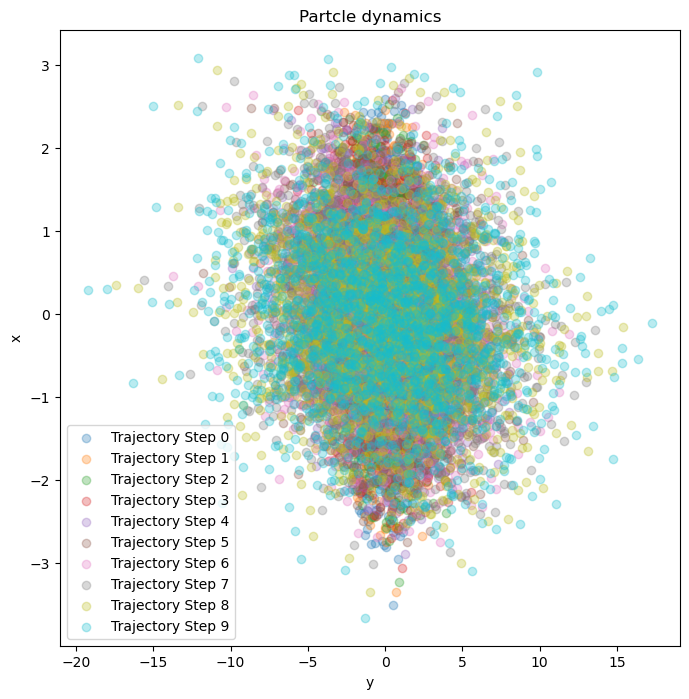

In [15]:
key,subkey = jax.random.split(key)
test_data_set = jax.random.normal(subkey, (2000, dim))

fig = plt.figure(figsize=(8,8))

ax_0 = 0
ax_1 = 1

for i, theta in enumerate(theta_history_optimal):
    samples = parametric_model(samples=test_data_set, params=theta)
    plt.scatter(samples[:,ax_0], samples[:,ax_1], alpha=0.3,label=f'Trajectory Step {i}')
    if i == 0:
        initial_samples = samples
    if i == len(theta_history_optimal)-1:
        mapped_samples = samples
plt.title("Partcle dynamics")
plt.xlabel("y")
plt.ylabel("x")
plt.legend()
plt.show()

In [16]:
def monge_map(samples: Array, sigma_target: Array) -> Array:
    '''
    Compute the Monge from samples to the target Gaussian. As rho_0 = I, then the Monge map is given by:
        T(x) = A x, with A = (sigma_target)^{1/2}
    
    Args:
        samples: (N, d) array of samples from the source distribution
        sigma_target: (d, d) covariance matrix of the target Gaussian
    Outputs:
        mapped_samples: (N, d) array of samples mapped to the target Gaussian
    '''
    # Compute the matrix A = (sigma_target)^{1/2}
    eigvals,eigvec = jnp.linalg.eigh(sigma_target)
    A = eigvec @ jnp.diag(jnp.sqrt(eigvals))@eigvec.T
    # Apply the linear map
    y = samples @ A.T
    return y

def phi_monge_map(t: float, x: Array)->Array:
    '''
    Compute phi(t,x) such that nabla_x phi(0,x) = T(x), with T(x) = A x
    '''
    # Compute the matrix A = (sigma_target)^{1/2}
    eigvals,eigvec = jnp.linalg.eigh(Sigma_target)
    A = eigvec @ jnp.diag(jnp.sqrt(eigvals))@eigvec.T
    # Compute phi(t,x) = 0.5 x^T A x
    return 0.5*x.T @ A @ x


In [17]:
true_mapped_samples = monge_map(initial_samples, Sigma_target)

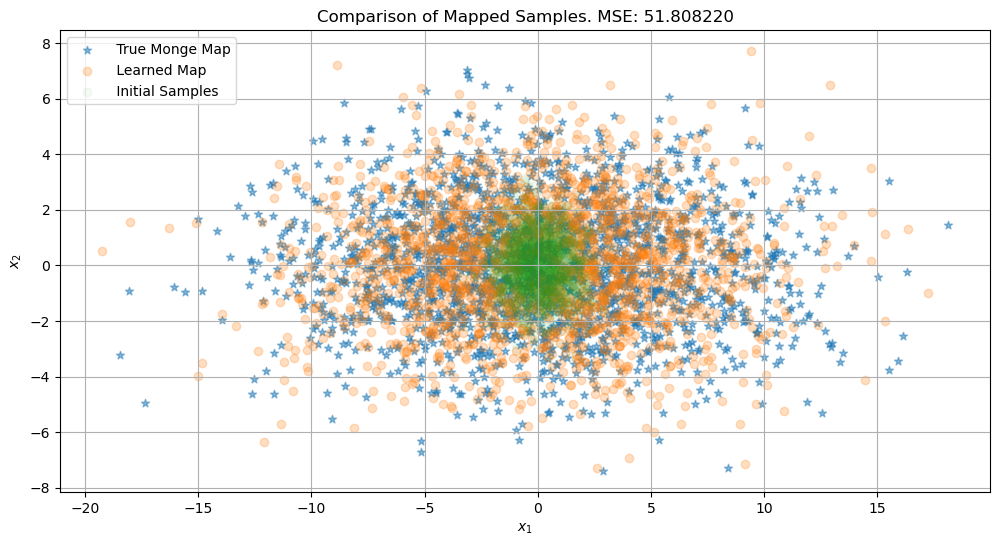

In [18]:
# Compute MSE between the learned coupling and the true coupling
mse = jnp.mean(jnp.linalg.norm(true_mapped_samples-mapped_samples,axis = 1)**2)
ax_0 =0
ax_1 =8
# Comparison of obtained samples vs true Monge map
plt.figure(figsize=(12,6))

plt.scatter(true_mapped_samples[:,ax_0],true_mapped_samples[:,ax_1], marker = '*',label=' True Monge Map',alpha=0.5)
plt.scatter(mapped_samples[:,ax_0],mapped_samples[:,ax_1],label=' Learned Map',alpha=0.25)
plt.scatter(initial_samples[:,ax_0],initial_samples[:,ax_1],label = ' Initial Samples', alpha = 0.05)
plt.title("Comparison of Mapped Samples. MSE: {:.6f}".format(mse))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.grid(True)
plt.legend()

In [ ]:
# Comparison of distance estimated by distance vs by the action. 
action = results['final_action']
# Estimated Wasserstein distance
estimated_distance = jnp.sqrt(jnp.mean(jnp.linalg.norm(true_mapped_samples-initial_samples,axis=1)**2))
print(f"Estimated Wasserstein Distance from Samples: {estimated_distance:.6f}")
print(f"Estimated Wasserstein Distance from Action: {jnp.sqrt(action):.6f}")

Estimated Wasserstein Distance from Samples: 6.914570
Estimated Wasserstein Distance from Action: 8.054384


: 